{'T': [10], 'k': [100, 500], 'epochs': [1], 'uncertainty_sampling_method': ['entropy'], 'alpha': [0.2, 0.5], 'num_clusters': [3, 10]} [{'T': 10, 'k': 100, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.2, 'num_clusters': 3}, {'T': 10, 'k': 100, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.2, 'num_clusters': 10}, {'T': 10, 'k': 100, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.5, 'num_clusters': 3}, {'T': 10, 'k': 100, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.5, 'num_clusters': 10}, {'T': 10, 'k': 500, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.2, 'num_clusters': 3}, {'T': 10, 'k': 500, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.2, 'num_clusters': 10}, {'T': 10, 'k': 500, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.5, 'num_clusters': 3}, {'T': 10, 'k': 500, 'epochs': 1, 'uncertainty_sampling_method': 'entropy', 'alpha': 0.5, 'num_clust

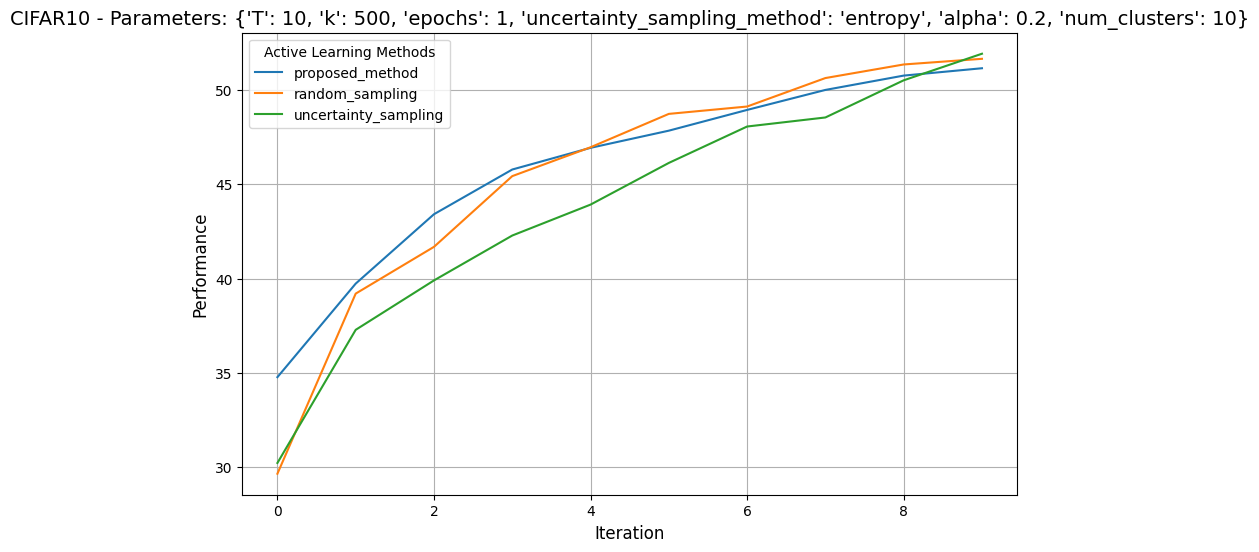

In [10]:
import pandas as pd
from datetime import datetime
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import itertools
from typing import Dict, List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.cluster import KMeans

global_results = []


def grid_search_params(hyperparams: Dict[str, List]) -> List[Dict]:
    """
    Generates all possible combinations of hyperparameters for grid search.

    :param hyperparams: A dictionary where keys are hyperparameter names and values are lists of possible values.
    :return: A list of dictionaries, each representing a combination of hyperparameters.
    """
    # Get all combinations of the hyperparameters
    param_combinations = list(itertools.product(*hyperparams.values()))

    # Create a list of dictionaries for each combination
    result = [dict(zip(hyperparams.keys(), combination)) for combination in param_combinations]
    return result

class LabeledUnlabeledDataset:
    def __init__(self, dataset_name, labeled_ratio=0.1):
        """
        Initializes the dataset by separating it into labeled and unlabeled data.

        Parameters:
            dataset: The PyTorch dataset (e.g., CIFAR-10).
            labeled_ratio: The initial ratio of labeled data in the dataset.
        """
        if dataset_name == "CIFAR10":
            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            input_cahnnels = 3
            dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
            test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        elif dataset_name == "MNIST":
            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
            input_cahnnels = 1
            dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
            test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        else:
            raise ValueError("Invalid dataset name")
        self.dataset_name = dataset_name
        self.dataset = dataset
        self.test_dataset = test_dataset
        self.input_channels = input_cahnnels
        self.number_of_classes = len(dataset.classes)
        self.total_data = len(self.dataset)
        self.labeled_data = set(random.sample(range(self.total_data), int(self.total_data * labeled_ratio)))
        self.unlabeled_data = set(range(self.total_data)) - self.labeled_data
        self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    def get_dataset_name(self):
        """Returns the name of the dataset."""
        return self.dataset_name

    def get_input_channels(self):
        """Returns the number of input channels in the dataset."""
        return self.input_channels

    def get_number_of_classes(self):
        """Returns the classes in the dataset."""
        return self.number_of_classes

    def get_dataset_length(self):
        """Returns the total length of the dataset."""
        return self.total_data

    def get_labeled_indices(self):
        """Returns the indices of the labeled data."""
        return list(self.labeled_data)

    def get_unlabeled_indices(self):
        """Returns the indices of the unlabeled data."""
        return list(self.unlabeled_data)

    def update_labeled_data(self, new_labeled_indices):
        """
        Updates the labeled data with new indices.

        Parameters:
            new_labeled_indices: Indices of the newly labeled data to be added.
        """
        self.labeled_data.update(new_labeled_indices)
        self.unlabeled_data -= set(new_labeled_indices)

    def update_unlabeled_data(self, new_unlabeled_indices):
        """
        Updates the unlabeled data with new indices.

        Parameters:
            new_unlabeled_indices: Indices of the newly unlabeled data to be added.
        """
        self.unlabeled_data.update(new_unlabeled_indices)
        self.labeled_data -= set(new_unlabeled_indices)

    def get_labeled_data_loader(self, batch_size=64):
        """Returns a DataLoader for the labeled data."""
        labeled_indices = self.get_labeled_indices()
        labeled_dataset = torch.utils.data.Subset(self.dataset, labeled_indices)
        return DataLoader(labeled_dataset, batch_size=batch_size, shuffle=False)

    def get_unlabeled_data_loader(self, batch_size=64):
        """Returns a DataLoader for the unlabeled data."""
        unlabeled_indices = self.get_unlabeled_indices()
        unlabeled_dataset = torch.utils.data.Subset(self.dataset, unlabeled_indices)
        return DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

    def get_test_data_loader(self):
        """Returns a DataLoader for the test data."""
        return self.test_loader

def create_model(model_name, data, param):
    class CNN(nn.Module):
            def __init__(self):
                super(CNN, self).__init__()
                self.conv1 = nn.Conv2d(in_channels=data.get_input_channels(), out_channels=16, kernel_size=3, padding=1)
                self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
                self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
                self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                if data.get_dataset_name() == "CIFAR10":
                    self.fc1 = nn.Linear(1024, 128)
                elif data.get_dataset_name() == "MNIST":
                    self.fc1 = nn.Linear(64 * 7 * 7, 128)
                else:
                    raise ValueError("Invalid dataset name")
                self.fc2 = nn.Linear(128, data.get_number_of_classes())  # 10 output classes for MNIST

            def forward(self, x):
                x = self.pool(torch.relu(self.conv1(x)))
                x = self.pool(torch.relu(self.conv2(x)))
                x = self.pool(torch.relu(self.conv3(x)))
                x = torch.flatten(x, 1)  # Flatten the tensor
                x = torch.relu(self.fc1(x))
                x = self.fc2(x)
                return x

            def return_cnn_features(self, x):
                x = self.pool(torch.relu(self.conv1(x)))
                x = self.pool(torch.relu(self.conv2(x)))
                x = self.pool(torch.relu(self.conv3(x)))
                x = torch.flatten(x, 1)  # Flatten the tensor
                return x

    model = CNN()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

def train_model(data, model, param):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = data.get_labeled_data_loader()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    epochs = param["epochs"]
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update the weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

def evaluate_model(data, model, metric_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = data.get_test_data_loader()
    model.eval()  # Set the model to evaluation mode
    if metric_name == "accuracy":
        correct = 0
        total = 0
        with torch.no_grad():  # No need to compute gradients for evaluation
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Test Accuracy: {100 * correct / total:.2f}%')
        return 100 * correct / total
    else:
        raise ValueError("Invalid metric name")

def random_sampling(data, model, param):
    total_data = data.get_dataset_length()
    unlabeled_data = data.get_unlabeled_indices()
    random_indices = random.sample(unlabeled_data, param["k"])
    data.update_labeled_data(random_indices)

def uncertainty_sampling(data, model, param):
    """
    Performs uncertainty sampling on the unlabeled dataset using one of three methods:
    Least Confidence, Least Margin, or Entropy.

    Parameters:
        data: LabeledUnlabeledDataset object.
        model: PyTorch model used for predictions.
        param: A dictionary with the following keys:
            - 'k': Number of samples to select.
            - 'method': Uncertainty estimation method ('least_confidence', 'least_margin', or 'entropy').
    """
    # Ensure the model is in evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Get the unlabeled data loader
    unlabeled_loader = data.get_unlabeled_data_loader(batch_size=64)

    # Store uncertainties and indices
    uncertainties = []
    indices = data.get_unlabeled_indices()

    with torch.no_grad():
        for batch_indices, (images, _) in enumerate(unlabeled_loader):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Compute softmax probabilities

            # Compute uncertainty scores
            if param['uncertainty_sampling_method'] == 'least_confidence':
                uncertainty = -torch.max(probs, dim=1).values
            elif param['uncertainty_sampling_method'] == 'least_margin':
                top_probs, _ = torch.topk(probs, 2, dim=1)
                uncertainty = -(top_probs[:, 0] - top_probs[:, 1])
            elif param['uncertainty_sampling_method'] == 'entropy':
                uncertainty = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            else:
                raise ValueError("Invalid uncertainty_sampling_method. Choose from 'least_confidence', 'least_margin', or 'entropy'.")

            # Append uncertainties and indices
            uncertainties.extend(uncertainty.cpu().numpy())

    # Select the top-k most uncertain samples
    k = param['k']
    uncertain_indices = sorted(
        range(len(uncertainties)), key=lambda i: uncertainties[i], reverse=True
    )[:k]

    # Get the original indices of the selected samples
    selected_indices = [indices[i] for i in uncertain_indices]

    # Update labeled and unlabeled data in the dataset
    data.update_labeled_data(selected_indices)

###############################################################################################################
def proposed_method(data, model, param):
    """
    Implements the proposed active learning method that combines uncertainty estimation and clustering.

    Parameters:
        data: LabeledUnlabeledDataset object.
        model: PyTorch model used for feature extraction and predictions.
        param: A dictionary with the following keys:
            - 'k': Total number of samples to select.
            - 'alpha': Proportion of samples selected based on uncertainty (0 < alpha <= 1).
            - 'uncertainty_method': Uncertainty estimation method ('least_confidence', 'least_margin', or 'entropy').
            - 'num_clusters': Number of clusters for diversity selection.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Extract features and uncertainties from unlabeled data
    unlabeled_loader = data.get_unlabeled_data_loader()
    uncertainties = []
    features = []
    indices = data.get_unlabeled_indices()

    with torch.no_grad():
        for (images, _) in unlabeled_loader:
            images = images.to(device)

            # Forward pass to get predictions and features
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Compute softmax probabilities
            features_batch = model.return_cnn_features(images)  # Extract feature vectors

            # Compute uncertainty scores
            if param['uncertainty_sampling_method'] == 'least_confidence':
                uncertainty = -torch.max(probs, dim=1).values
            elif param['uncertainty_sampling_method'] == 'least_margin':
                top_probs, _ = torch.topk(probs, 2, dim=1)
                uncertainty = -(top_probs[:, 0] - top_probs[:, 1])
            elif param['uncertainty_sampling_method'] == 'entropy':
                uncertainty = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            else:
                raise ValueError("Invalid uncertainty method. Choose from 'least_confidence', 'least_margin', or 'entropy'.")

            uncertainties.extend(uncertainty.cpu().numpy())
            features.extend(features_batch.cpu().numpy())

    # Step 1: Select top αK uncertain samples
    k = param['k']
    alpha = param['alpha']
    num_uncertain_samples = int(alpha * k)

    uncertain_indices = sorted(
        range(len(uncertainties)), key=lambda i: uncertainties[i], reverse=True
    )[:num_uncertain_samples]

    S_u = [indices[i] for i in uncertain_indices]
    F_u = np.array([features[i] for i in uncertain_indices])  # Corresponding feature vectors

    # Step 2: Cluster the feature vectors of uncertain samples
    num_clusters = param['num_clusters']
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(F_u)
    cluster_centroids = kmeans.cluster_centers_

    # Step 3: Select (1-α)K diverse samples
    num_diverse_samples = k - num_uncertain_samples
    S_c = []
    distances = []

    for idx, feature in enumerate(features):
        if idx in uncertain_indices:
            continue  # Skip already selected uncertain samples
        feature = np.array(feature)
        distance = np.min([np.linalg.norm(feature - centroid) for centroid in cluster_centroids])
        distances.append((indices[idx], distance))

    # Sort by distance to nearest cluster centroid and select the top (1-α)K samples
    distances.sort(key=lambda x: x[1], reverse=True)
    S_c = [sample[0] for sample in distances[:num_diverse_samples]]

    # Step 4: Update the labeled set
    selected_indices = set(S_u + S_c)
    data.update_labeled_data(selected_indices)


def active_learning(data, model, active_learning_method, param):
    method_map = {
        "random_sampling": random_sampling,
        "uncertainty_sampling": uncertainty_sampling,
        "proposed_method": proposed_method
    }
    if active_learning_method in method_map:
        return method_map[active_learning_method](data, model, param)
    else:
        raise ValueError("Invalid active learning method")

def run_experement(data_set: str, model_name: str, param: Dict, metric_name: str, active_learning_method: str) -> List[float]:
    """
    Run experement with given parameters
    :param data_set: name of the data set to use.
    :param model_name: name of the model to use.
    :param param: parameter to use. where the key is the name of the hyperparameter and the value is the value of the hyperparameter.
    :param metric_name: name of the metric to use.
    :param active_learning_method: name of the active learning method to use.
    :return:  list with the metric on the test set, lengt of the list is the number of iterations.
    """
    np.random.seed(0)  # For reproducibility

    data = LabeledUnlabeledDataset(data_set)
    model = create_model(model_name, data, param)
    T = param["T"]
    metric = []
    for t in range(T):
        print(f"Iteration {t+1}/{T}")
        train_model(data, model, param)
        m = evaluate_model(data, model, metric_name)
        metric.append(m)
        active_learning(data, model, active_learning_method, param) # updates the dataset
    return metric

# experemets grid
def run_experements(data_sets: List[str], models: List[str], metrics: List[str], grid_params: Dict, active_learning_methods: List[str]):
    """
    Run experements with grid params
    :param data_sets: list of the names of the data sets to use.
    :param models: list of the names of the models to use.
    :param metrics: list of the names of the metrics to use.
    :param grid_params: grid params to use.
    :param active_learning_methods: list of the names of the active learning methods to use.
    :return: final results. dictionary
    """
    time_start = datetime.now()
    final_results = {}
    best_params = {}
    best_metric = {}
    param_combinations = grid_search_params(grid_params)
    print(grid_params,param_combinations)
    for data_set in data_sets:
        for model_name in models:
            for metric_name in metrics:
                for param in param_combinations:
                    for active_learning_method in active_learning_methods:
                        print(f"Running experement: {data_set} {model_name} {metric_name} {param} {active_learning_method}")
                        print(f"Time: {datetime.now() - time_start}")
                        metric = run_experement(data_set, model_name, param, metric_name, active_learning_method) # metric is a list with the metric on the test set, lengt of the list is the number of iterations.
                        if metric[-1] > best_metric.get((data_set, metric_name, active_learning_method), 0):
                            best_metric[(data_set, metric_name, active_learning_method)] = metric[-1]
                            best_params[(data_set, metric_name, active_learning_method)] = param
                        final_results[(data_set, model_name, metric_name, tuple(param.items()), active_learning_method)] = metric
    return final_results, best_params, best_metric

def plot_results_good(final_results, best_params, active_learning_methods, data_sets):
    """
    Creates a plot for each dataset showing the performance of all active learning methods.

    Parameters:
        final_results (dict): Results for each method and dataset.
        best_params (dict): Best parameters for each dataset and method.
        active_learning_methods (list): List of active learning methods.
        data_sets (list): List of datasets.
    """
    for dataset in data_sets:
        plt.figure(figsize=(10, 6))

        for method in active_learning_methods:
            # Filter final_results to get the specific data for this dataset and method
            results_key = tuple(k for k in final_results.keys() if k[0] == dataset and k[-1] == method)
            if results_key:
                results_key = results_key[0]
                performance = final_results[results_key]
                plt.plot(range(len(performance)), performance, label=method)

        # Construct a title with the parameters
        title_key = tuple(k for k in best_params.keys() if k[0] == dataset)
        if title_key:
            title_key = title_key[0]
            params = best_params[title_key]
            title = f"{dataset} - Parameters: {params}"
        else:
            title = dataset

        plt.title(title, fontsize=14)
        plt.xlabel("Iteration", fontsize=12)
        plt.ylabel("Performance", fontsize=12)
        plt.legend(title="Active Learning Methods", fontsize=10)
        plt.grid(True)

        # Save the plot
        plt.savefig(f"{dataset}_performance_plot.png", bbox_inches='tight')
        plt.show()

def main():
    data_sets = ["CIFAR10"]
    models = ["CNN"]
    metrics = ["accuracy"]
    grid_params = {"T": [10],
                   "k": [100,500],
                   "epochs": [1],
                   "uncertainty_sampling_method": ["entropy"],
                   "alpha":[0.2, 0.5],
                   "num_clusters":[3, 10]}
    active_learning_methods = [ "proposed_method", "random_sampling", "uncertainty_sampling"]
    final_results, best_params, best_metric = run_experements(data_sets, models, metrics, grid_params, active_learning_methods)
    global_results.append(final_results)
    global_results.append(best_params)
    global_results.append(best_metric)
    print(final_results)
    print(best_params)
    print(best_metric)
    plot_results_good(final_results, best_params, active_learning_methods, data_sets)

if __name__ == "__main__":
    main()